In [2]:
import pandas as pd 
import sklearn as sk
import numpy as np
import talib 
from talib import abstract
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, XGBClassifier
import tuneta
import pandas_ta as ta
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import lightgbm as lgb



In [3]:
label = pd.read_csv("10_label.csv")
margin = pd.read_csv("10_feature_past_6_months_margin_short.csv")
ohlcv = pd.read_csv("10_feature_past_6_months_ohlcv.csv")
trans = pd.read_csv("transaction_details.csv")
industry = pd.read_csv("stock_industry.csv")

In [4]:
def calculate_feature(id):
    output = pd.DataFrame()
    for j in range(len(label[label["stock_id"] == id])):
        df = ohlcv[ohlcv["stock_id"] == id].drop(columns=["stock_id","date"]).iloc[j*180:(j+1)*180]
        date = ohlcv[ohlcv["stock_id"] == id][["date","stock_id"]].iloc[j*180:(j+1)*180]
        df = df.astype('float')
        for i in talib.get_functions():
            try:
                # result = eval('abstract.' + {i} + f'ohlcv[ohlcv["stock_id"] == "{2330}"])')
                result = eval('abstract.'+ i + f'(ohlcv[ohlcv["stock_id"] == {id}])')

                result.name = i.lower() if type(result) == pd.core.series.Series else None
                df = pd.merge(df,pd.DataFrame(result),left_on= df.index,right_on=result.index)
                df = df.set_index("key_0")
            except:
                print(i)
        df = pd.merge(date,df,left_index=True,right_index=True) # Specify left_on parameter
        space = pd.merge(df.tail(1),label[label["stock_id"] == id].iloc[j:j + 1],on="stock_id")
        print(j)
        output = pd.concat([output,space])
    return output
        
    
def classify_to_binary(profit):
    if profit > 24:
        return 0
    else:
        return 1

def classify(profit):
    if profit > 24:
        return 0
    elif profit >= 13:
        return 1
    elif profit >= 1.08:
        return 2
    else :
        return 3

In [ ]:
result = pd.DataFrame()
for id in ohlcv["stock_id"].unique():
    out = calculate_feature(id)
    result = pd.concat([result,out])
    

In [63]:
result['date'] = pd.to_datetime(result['date'])

In [64]:
test = result.copy()


In [67]:
test[["date"]].dtypes

date    datetime64[ns]
dtype: object

In [71]:
test["binary classify"] = test["profit(%)"].apply(classify_to_binary)

In [72]:
test["non binary"] = test["profit(%)"].apply(classify)

In [73]:
for col in test.columns:
    if test[col].dtype == "int32":
        test[col] = test[col].astype("float64")

Training for Binary Classification

In [86]:
X = test.copy().drop(columns=["Unnamed: 0_x","open","close","high","low", "stock_id","acos","asin","profit(%)","buy_price","buy_date", "sell_date","binary classify","volume","amount","cosh","exp","sinh","Unnamed: 0_y","sell_price","sell_price","lowest_price","highest_price","MAE","BMFE","GMFE","non binary"])
X_train = X[X['date'].dt.year <= 2020].drop(columns=["date"])
X_test = X[X['date'].dt.year >= 2021].drop(columns=["date"])
y_train = test[test['date'].dt.year <= 2020][["binary classify"]]
y_test = test[test['date'].dt.year >= 2021][["binary classify"]]

array([[<Axes: title={'center': 'binary classify'}>]], dtype=object)

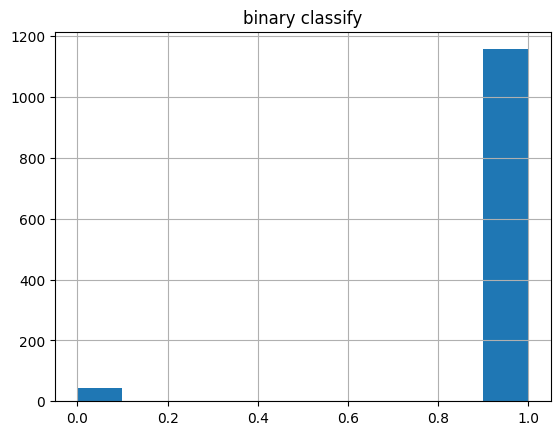

In [84]:
test[["binary classify"]].hist()

In [29]:
# import numpy as np

# # Assuming 'X' is your DataFrame or array
# # Find max value
# max_value = np.max(np.abs(X), axis=0)

# # Check if max value is too large for float32
# max_float32 = np.finfo(np.float32).max
# # if np.any(max_value >= max_float32):
    
# #     print("There are values too large for dtype('float32').")
# for max in max_value:
#     if max >= max_float32:
#        print(max)
#        print("There are values too large for dtype('float32').")
       

下降 成float 32

In [30]:
# import numpy as np
# import pandas as pd

# # Assuming 'X' is a pandas DataFrame
# max_float32 = np.finfo(np.float32).max

# # Find columns with max value greater than or equal to max_float32
# columns_with_large_values = [column for column in X if np.any(np.abs(X[column]) >= max_float32)]

# # Print the columns
# print("Columns with values too large for float32:", columns_with_large_values)


Columns with values too large for float32: []


In [87]:

xgb_classfier = XGBClassifier().fit(X_train, y_train)
# xgb_classfier = xgb_classfier.fit(X_train, y_train)

In [88]:
accuracy_score(xgb_classfier.predict(X_test),y_test)

0.9533169533169533

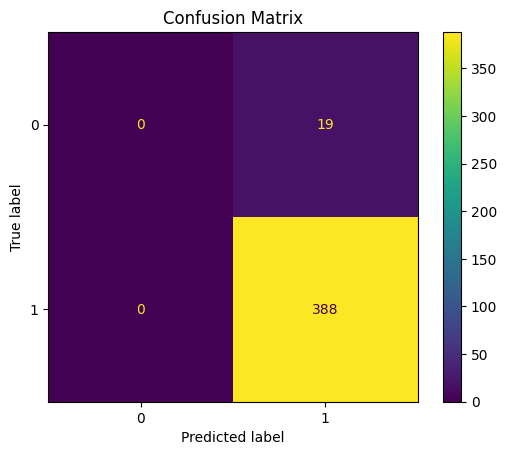

In [89]:
y_pred = xgb_classfier.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
ConfusionMatrixDisplay(cm).plot(values_format='d')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
y_test.sum()

binary_classify    238
dtype: int64

Training for non classifcation

拿2020前資料當train model, 2020 年後當test

In [90]:
X = test.copy().drop(columns=["Unnamed: 0_x","open","close","high","low", "stock_id","acos","asin","profit(%)","buy_price","buy_date", "sell_date","binary classify","volume","amount","cosh","exp","sinh","Unnamed: 0_y","sell_price","sell_price","lowest_price","highest_price","MAE","BMFE","GMFE","non binary"])
X_train = X[X['date'].dt.year <= 2020].drop(columns=["date"])
X_test = X[X['date'].dt.year >= 2021].drop(columns=["date"])
y_train = test[test['date'].dt.year <= 2020][["non binary"]]
y_test = test[test['date'].dt.year >= 2021][["non binary"]]
# X_train, X_test, y_train, y_test = train_test_split(X, test[["non binary"]], test_size=0.2, random_state=42)

In [ ]:
# X = X.sort_values(by="date")
# X

In [ ]:
def sanitize_column_name(column_name):
    # Define a dictionary of JSON special characters to be replaced or removed
    # You might want to replace these characters with an underscore or remove them
    replacements = {
        '[': '',
        ']': '',
        '{': '',
        '}': '',
        ':': '',
        ',': '',
        '"': '',
        '_': ''
    }
    
    # Replace special characters based on the dictionary
    for old_char, new_char in replacements.items():
        column_name = column_name.replace(old_char, new_char)
    
    return column_name

# Sanitize each column name using a for loop
new_columns = [sanitize_column_name(col) for col in X.columns]

# Assign the sanitized column names back to the DataFrame
X.columns = new_columns


In [95]:

xgb_classfier = XGBClassifier(eta = 0.001).fit(X_train, y_train)
accuracy_score(y_test, xgb_classfier.predict(X_test))


0.45454545454545453

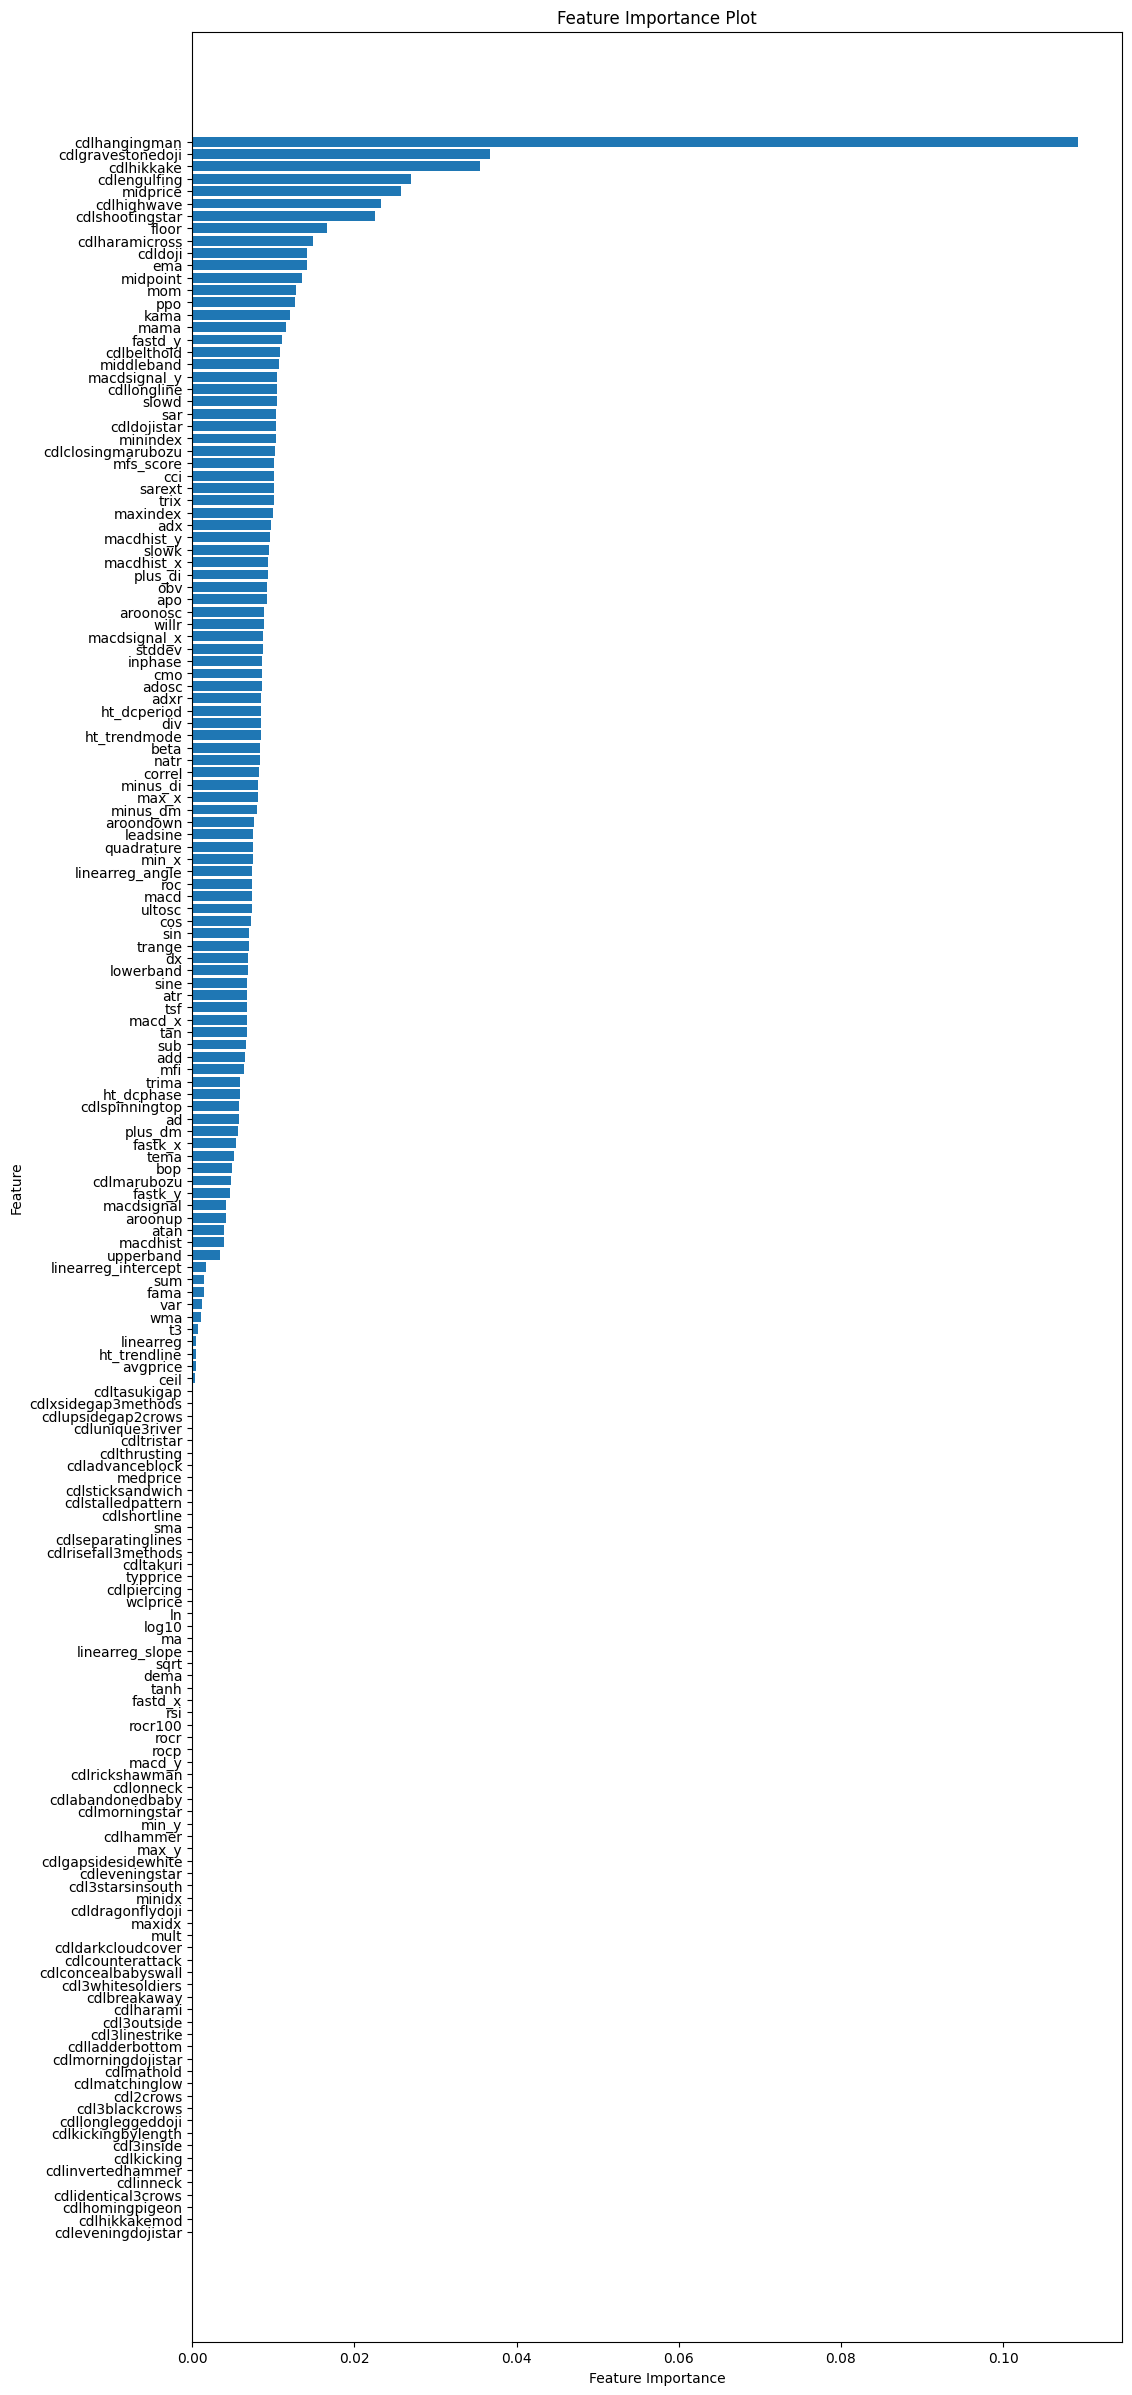

In [79]:

# Assuming your classifier is named `xgb_classfier` and it has been fit to your data

# Get feature importances
feature_importance = xgb_classfier.feature_importances_
# Get feature names
feature_names = X_train.columns
# Create a DataFrame to hold feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# Sort by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)
# Plot feature importances
plt.figure(figsize=(12, 30))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.gca().invert_yaxis()  # Invert the Y-axis to have the most important feature on top
plt.show()

Traing lgm classifier

In [ ]:
import json

# Python dictionary
data = {
    "name": "John Doe",
    "age": 30,
    "is_member": True,
    "skills": ["Python", "Machine Learning"]
}

# Convert the Python dictionary to a JSON-formatted string
json_str = json.dumps(data)
print(json_str)

# Convert a JSON-formatted string back to a Python dictionary
data_from_json = json.loads(json_str)
print(data_from_json)


{"name": "John Doe", "age": 30, "is_member": true, "skills": ["Python", "Machine Learning"]}
{'name': 'John Doe', 'age': 30, 'is_member': True, 'skills': ['Python', 'Machine Learning']}


In [ ]:
for col in X.columns:
    print(col)

In [80]:

xgb_classfier = lgb.LGBMClassifier().fit(X_train, y_train)
accuracy_score(y_test, xgb_classfier.predict(X_test))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002961 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25457
[LightGBM] [Info] Number of data points in the train set: 793, number of used features: 124
[LightGBM] [Info] Start training from score -3.497769
[LightGBM] [Info] Start training from score -2.784003
[LightGBM] [Info] Start training from score -0.838093
[LightGBM] [Info] Start training from score -0.743578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

0.4348894348894349

In [ ]:
pd.merge(df.tail(1),label[label["stock_id"] == 2330].head(1),on="stock_id")

In [ ]:
# output = pd.DataFrame()
# for j in range(len(label[label["stock_id"] == 2330.0])):
#     df = ohlcv[ohlcv["stock_id"] == 2330].drop(columns=["stock_id","date"]).iloc[j*180:(j+1)*180]
#     date = ohlcv[ohlcv["stock_id"] == 2330][["date","stock_id"]].iloc[j*180:(j+1)*180]
#     df = df.astype('float')
#     for i in talib.get_functions():
#         try:
#             result = eval('abstract.'+ i + '(ohlcv[ohlcv["stock_id"] == 2330])')
#             result.name = i.lower() if type(result) == pd.core.series.Series else None
#             df = pd.merge(df,pd.DataFrame(result),left_on= df.index,right_on=result.index)
#             df = df.set_index("key_0")
#         except:
#             print(i)
#     df = pd.merge(date,df,left_index=True,right_index=True) # Specify left_on parameter
#     space = pd.merge(df.tail(1),label[label["stock_id"] == 2330].iloc[j:j + 1],on="stock_id")
#     print(j)
#     output = pd.concat([output,space])
    
    


In [ ]:
radius = float(input('Enter the radius of the circle:.'))
area=3.14* radius**2
print("The area of the circle is", area)

The area of the circle is 254.34
